In [27]:
import numpy as np
import torch

DATA = Path("../data")
FIGS = Path("../reports/figures")

d = np.load(DATA/"preproc_fake_seq31.npz")
X_train, y_train = d["X_train"], d["y_train"]
X_val,   y_val   = d["X_val"],   d["y_val"]
X_test,  y_test  = d["X_test"],  d["y_test"]

X_train.shape, y_train.shape


((4, 31, 4), (4,))

In [18]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [19]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)
test_ds  = TensorDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2)
test_loader  = DataLoader(test_ds, batch_size=2)

In [20]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        self.fc = nn.Linear(16 * 13, 2)  # 31bp → conv → pool = length 13

    def forward(self, x):
        x = x.permute(0, 2, 1)         # (B, 31,4) → (B,4,31)
        x = self.relu(self.conv(x))    # convolution learns patterns
        x = self.pool(x)               # downsample
        x = self.flat(x)               # flatten
        x = self.fc(x)                 # class scores
        return x

model = SimpleCNN()
model


SimpleCNN(
  (conv): Conv1d(4, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=208, out_features=2, bias=True)
)

In [21]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
train_losses = []
val_accs = []

In [23]:
EPOCHS = 20

for epoch in range(EPOCHS):
    # ---- Training ----
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    # ---- Validation ----
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            preds = model(Xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1: Loss = 0.7080, Val Acc = 0.5000
Epoch 2: Loss = 0.6897, Val Acc = 0.5000
Epoch 3: Loss = 0.6615, Val Acc = 0.5000
Epoch 4: Loss = 0.6421, Val Acc = 0.5000
Epoch 5: Loss = 0.6270, Val Acc = 0.5000
Epoch 6: Loss = 0.6057, Val Acc = 0.5000
Epoch 7: Loss = 0.5879, Val Acc = 0.5000
Epoch 8: Loss = 0.5747, Val Acc = 0.5000
Epoch 9: Loss = 0.5560, Val Acc = 0.5000
Epoch 10: Loss = 0.5374, Val Acc = 0.5000
Epoch 11: Loss = 0.5236, Val Acc = 0.5000
Epoch 12: Loss = 0.5050, Val Acc = 0.5000
Epoch 13: Loss = 0.4911, Val Acc = 0.5000
Epoch 14: Loss = 0.4736, Val Acc = 0.5000
Epoch 15: Loss = 0.4584, Val Acc = 0.5000
Epoch 16: Loss = 0.4433, Val Acc = 0.5000
Epoch 17: Loss = 0.4286, Val Acc = 0.5000
Epoch 18: Loss = 0.4139, Val Acc = 0.5000
Epoch 19: Loss = 0.3993, Val Acc = 0.5000
Epoch 20: Loss = 0.3849, Val Acc = 0.5000


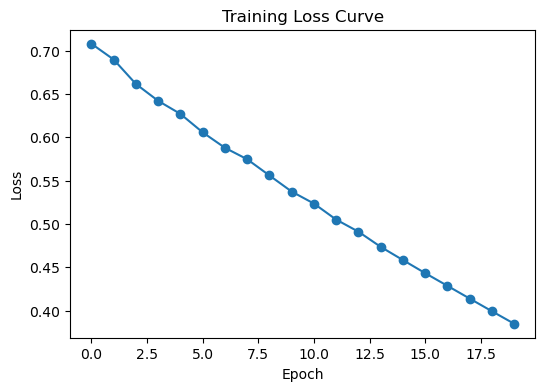

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.savefig(FIGS/"fakedata_training_loss_curve", dpi=200)
plt.show()


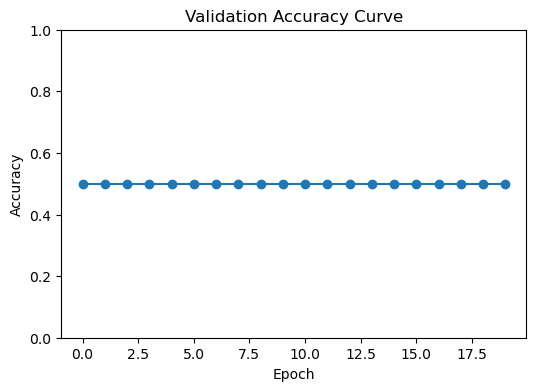

In [40]:
plt.figure(figsize=(6,4))
plt.plot(val_accs, marker='o')
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(False)
plt.savefig(FIGS/"fakedata_validation_accuracy_curve", dpi=200)
plt.show()


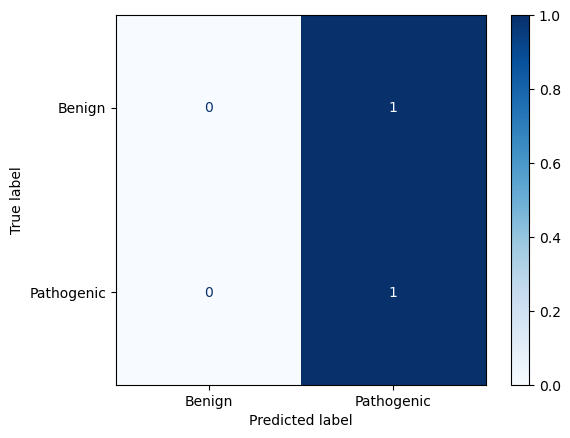

<Figure size 640x480 with 0 Axes>

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb).argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_true.extend(yb.tolist())

cm = confusion_matrix(all_true ,all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Pathogenic"])
disp.plot(cmap="Blues")
plt.show()
plt.savefig(FIGS/"fakedata_confusion_matrix", dpi=200)

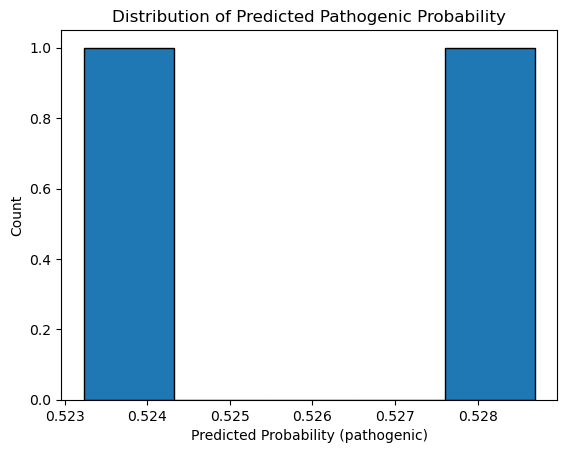

<Figure size 640x480 with 0 Axes>

In [42]:
import torch.nn.functional as F

model.eval()
probs = []

with torch.no_grad():
    for Xb, yb in test_loader:
        pred_logits = model(Xb)
        pred_prob = F.softmax(pred_logits, dim=1)[:,1]  # probability of pathogenic
        probs.extend(pred_prob.tolist())

plt.hist(probs, bins=5, edgecolor="black")
plt.title("Distribution of Predicted Pathogenic Probability")
plt.xlabel("Predicted Probability (pathogenic)")
plt.ylabel("Count")
plt.show()
plt.savefig(FIGS/"fakedata_Output_probability_histogram")

In [43]:
import pandas as pd
pd.DataFrame({
    "True label": all_true,
    "Predicted label": all_preds,
    "Predicted probability (pathogenic)": [round(p,3) for p in probs]
})

,True label,Predicted label,Predicted probability (pathogenic)
0,1,1,0.523
1,0,1,0.529
